<div style="font-size:30px;color:#3665af;background-color:#E9E9F5;padding:10px;">Assignment Hands-on 

<div style="font-size:20px;color:#F1F8FC;background-color:#0095EA;padding:10px;">1. Setup </div>

- Visualize the position data, get some intuition about the geography
- Reduce the columns to the ones related to position and speed

In [2]:
!pip install scikit-learn

  Using cached scikit_learn-1.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.6 MB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)


In [3]:
from sklearn import svm
from sklearn.model_selection import train_test_split
# import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [4]:
# this data comes from the US DoT data website
# it is from a trial of connected vehicles travelling between Laramie and Cheyenne, WY
# https://data.transportation.gov/Automobiles/Wyoming-CV-Pilot-Basic-Safety-Message-One-Day-Samp/9k4m-a3jc
dataSrc = pd.read_csv("data/Wyoming_CV_Pilot_Basic_Safety_Message_One_Day_Sample.csv", low_memory=False)

In [4]:
# looking for the "coreData" columns instead of the "metaData" columns 
allColumns = list(filter(lambda colName: colName.startswith('coreData'), dataSrc.columns))
allColumns

['coreData_msgCnt',
 'coreData_id',
 'coreData_secMark',
 'coreData_position_lat',
 'coreData_position_long',
 'coreData_elevation',
 'coreData_accelset_accelYaw',
 'coreData_accuracy_semiMajor',
 'coreData_accuracy_semiMinor',
 'coreData_transmission',
 'coreData_speed',
 'coreData_heading',
 'coreData_brakes_wheelBrakes_leftFront',
 'coreData_brakes_wheelBrakes_rightFront',
 'coreData_brakes_wheelBrakes_unavailable',
 'coreData_brakes_wheelBrakes_leftRear',
 'coreData_brakes_wheelBrakes_rightRear',
 'coreData_brakes_traction',
 'coreData_brakes_abs',
 'coreData_brakes_scs',
 'coreData_brakes_brakeBoost',
 'coreData_brakes_auxBrakes',
 'coreData_size',
 'coreData_position']

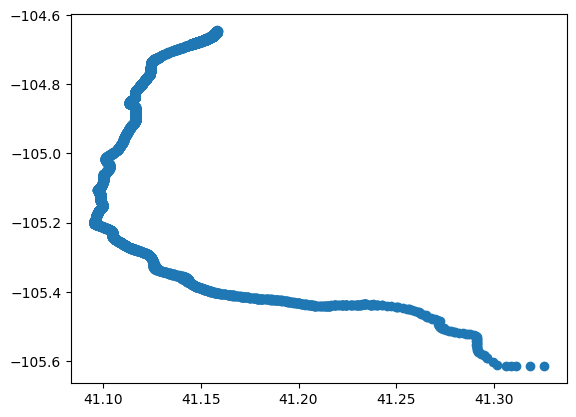

In [5]:
# this should resemble the roadway from Laramie, WY to Cheyenne, WY
plt.scatter(dataSrc['coreData_position_lat'], dataSrc['coreData_position_long'])

<img src="map-projection-of-data.png" alt="Map projection of data" style="width: 400px;"/>

Hmm, that roadway kind of looks similar, but, a little off. That's because we are treating latitude and longitude as euclidian coordinates, when they are actually coordinates projected onto a sphere.

Can we see a relationship between latitude values and elevation?

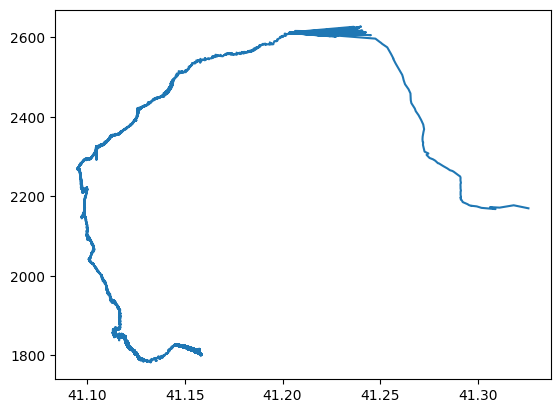

In [6]:
coordinateSortedData = dataSrc.sort_values(by=['coreData_position_long', 'coreData_position_lat'])
plt.plot(coordinateSortedData['coreData_position_lat'], coordinateSortedData['coreData_elevation'])

One issue we note with this immediately: latitude is not a valid function of elevation, since some latitude values project multiple values in elevation. In other words, there is no bijection between all latitude points and elevation points. 

What about with respect to the longitudinal data points?

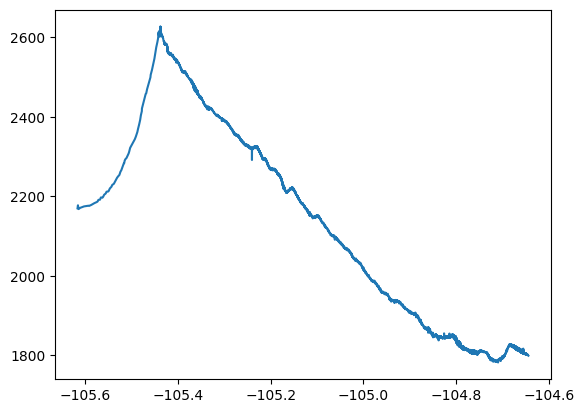

In [7]:
plt.plot(coordinateSortedData['coreData_position_long'], coordinateSortedData['coreData_elevation'])

Longitude appears to have a proper bijection to the domain of elevation points. We will consider this later when we build our linear model.

Wait, how many columns did our raw data have?

In [8]:
print(str(len(allColumns)) + " columns")

24 columns


We don't need all 24. Let's just focus in on the columns that are related to position and movement. We can even rename them to something easier on the eye.

In [9]:
dataSubset = dataSrc[['coreData_position_lat','coreData_position_long','coreData_secMark','coreData_elevation','coreData_speed', 'coreData_heading']]
dataSubset = dataSubset.rename(columns={'coreData_position_lat':'lat','coreData_position_long':'lon','coreData_secMark':'time','coreData_elevation':'height','coreData_speed':'speed', 'coreData_heading': 'direction'})
dataSubset

,lat,lon,time,height,speed,direction
0,41.126867,-104.727358,17100,1791.5,31.60,247.8375
1,41.126519,-104.728560,22600,1795.5,31.40,250.0625
2,41.127306,-104.725978,15200,1792.2,31.46,245.8625
3,41.126528,-104.728524,22500,1795.4,31.42,249.9625
4,41.127949,-104.724160,9800,1791.4,31.34,244.9125
...,...,...,...,...,...,...
32863,41.157918,-104.651846,4400,1804.1,23.74,259.6500
32864,41.156389,-104.659532,32200,1809.3,24.10,251.7250
32865,41.156152,-104.660456,35600,1810.6,24.14,249.9125
32866,41.156070,-104.660762,36700,1810.9,24.20,250.5875


Two of the columns are using the metric system. Here are two transforms we can use to switch away from the metric system to the USCU system (aka, feet and miles).

In [10]:
def metersToFeet(x):
    return x * 3.28084
def metersPerSecToMPH(x):
    return (metersToFeet(x) * 3600) / 5280

Let's convert the data in `dataSubset` from metric to our American distance measures, and store that in a new copy of the `dataSubset`. We do this because we want to manipulate data for analysis but maintain a copy without edits for any future analysis.

In [11]:
dataFt = dataSubset.copy()
dataFt['height'] = metersToFeet(dataSubset['height'])
dataFt['speed'] = metersPerSecToMPH(dataSubset['speed'])
dataFt

,lat,lon,time,height,speed,direction
0,41.126867,-104.727358,17100,5877.624860,70.687189,247.8375
1,41.126519,-104.728560,22600,5890.748220,70.239802,250.0625
2,41.127306,-104.725978,15200,5879.921448,70.374018,245.8625
3,41.126528,-104.728524,22500,5890.420136,70.284541,249.9625
4,41.127949,-104.724160,9800,5877.296776,70.105586,244.9125
...,...,...,...,...,...,...
32863,41.157918,-104.651846,4400,5918.963444,53.104869,259.6500
32864,41.156389,-104.659532,32200,5936.023812,53.910166,251.7250
32865,41.156152,-104.660456,35600,5940.288904,53.999644,249.9125
32866,41.156070,-104.660762,36700,5941.273156,54.133860,250.5875


Now, what can we say about these columns? One way to find out is to call `describe()` on each of them.

In [12]:
dataFt['lat'].describe()

count    32868.000000
mean        41.135849
std          0.020855
min         41.095102
25%         41.118991
50%         41.127936
75%         41.154254
max         41.325833
Name: lat, dtype: float64

In [13]:
dataFt['lon'].describe()

count    32868.000000
mean      -104.779413
std          0.170979
min       -105.616132
25%       -104.808981
50%       -104.730790
75%       -104.666441
max       -104.644505
Name: lon, dtype: float64

In [14]:
dataFt['height'].describe()

count    32868.000000
mean      6143.179182
std        502.818281
min       5845.472628
25%       5945.210164
50%       5969.160296
75%       6054.134052
max       8620.407100
Name: height, dtype: float64

<br>

<div style="font-size:20px;color:#F1F8FC;background-color:#0095EA;padding:10px;"> 2. A Regression Proof-of-concept </div>

Let's show ourselves that building a linear model does what we think it should do

- Let's predict elevation based on position
  - Let's make our first linear model _fit_ to the longitudinal data
  - We will try different features and different linear regression models
  - Recall from above, there was a fairly obvious relationship between longitude and elevation. We will let the models show us that this was a relevant detail.

Our first model makes the assumption that a linear model on an x/y coordinate pair can be used to infer height. Put another way, we will use `lat` and `lon` (our _features_) to predict `height` (our _label_), using a linear model of the form `c_1(lat) + c_2(lon)`, where we are attempting to learn the coefficients `c_1` and `c_2` that best fit our training data.

In [17]:
# this may take some time.
latLonModel = svm.SVR()
X_train, X_test, y_train, y_test = train_test_split(dataFt[['lat','lon']], dataFt['height'], test_size=0.2)
latLonModel.fit(X_train, y_train)

SVR()

In [18]:
predictions = latLonModel.predict(X_test)

Text(0, 0.5, 'Predictions')

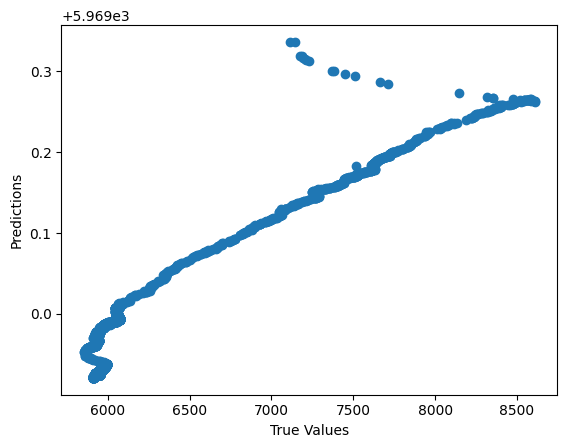

In [19]:
plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")

In [20]:
# how does it score?
print("Model Accuracy: {0:.2f}%".format(latLonModel.score(X_test, y_test) * 100))

Model Accuracy: -11.93%


This is not _bad_. It's also not _good_. Let's see if we can do better.

One common technique for fitting a regression model is to create **polynomial features**. These aim to create additional features that represent the polynomial terms of the inputs. For example, for some input column `x`, we can create additional columns to represent `x^2` and `x^3`.

In our case, let's see how creating an additional feature, `latlon` (computed as `latitude * longitude`) will help with our score.

In [21]:
polyFeatures = dataFt[['lat','lon']].copy()

# this is the line that adds a new column to polyFeatures that is the product of the columns lat and lon
polyFeatures['latlon'] = polyFeatures['lat'] * polyFeatures['lon']
polyFeatures

,lat,lon,latlon
0,41.126867,-104.727358,-4307.108086
1,41.126519,-104.728560,-4307.121086
2,41.127306,-104.725978,-4307.097343
3,41.126528,-104.728524,-4307.120643
4,41.127949,-104.724160,-4307.089949
...,...,...,...
32863,41.157918,-104.651846,-4307.252138
32864,41.156389,-104.659532,-4307.408437
32865,41.156152,-104.660456,-4307.421598
32866,41.156070,-104.660762,-4307.425708


Ok! Let's try with our new feature!

In [22]:
polyLonModel = svm.SVR()
X_train, X_test, y_train, y_test = train_test_split(polyFeatures[['lat','lon','latlon']], dataFt['height'], test_size=0.2)
polyLonModel.fit(X_train, y_train)

SVR()

In [23]:
predictions = polyLonModel.predict(X_test)

Text(0, 0.5, 'Predictions')

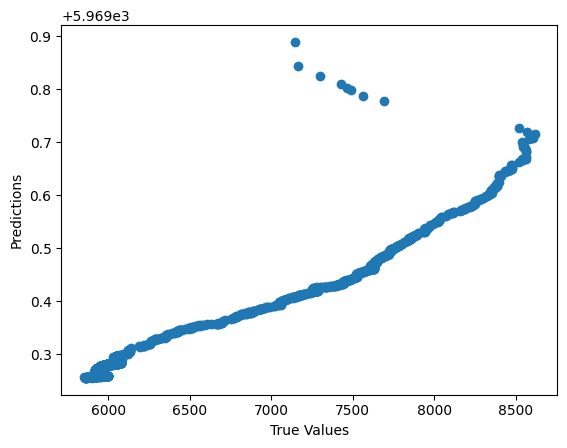

In [24]:
plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")

In [25]:
# how does it score?
print("Model Accuracy: {0:.2f}%".format(polyLonModel.score(X_test, y_test) * 100))

Model Accuracy: -11.54%


Much better! We doubled our accuracy without changing our model or data, but by coming up with more features from our data. Learning from the correct features is essential to good modeling.

<hr style="border-top: 5px solid purple; margin-top: 1px; margin-bottom: 1px"></hr>

<div style="font-size:30px;color:#3665af;background-color:#e1dfb1;padding:10px;">Exercise </div>

<div style="font-size:20px;color:#F1F8FC;background-color:#0095EA;padding:10px;"> 3. Let's Predict Speed</div>

Predicting speed will be a bit more challenging, but, we have some intuition. Perhaps there are properties related to the highway that might produce similar speed ratings, such as a steep climb on an eastbound section, or passing through a section where there was construction all day long. Think about what vehicle travel is like while you work on your model. 

#### Do not get lost attempting perfection! Grading will be based mostly on your answers to the questions below. Make a reasonable effort at refining your model, put a few hours into it, and explain your process for a passing grade.

##### In order to answer these questions, do the following:

- Use our data points to fit some of the data to a linear model
  - _important_: you will need to set `speed` to be your training label
- Experiment with different polynomial features
  - see polyLonModel, above, for an example
- Try changing the parameters of SVR, such as kernel, C, gamma, and degree, when appropriate
  - see the [SVR documentation](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR) for a detailed description of these options.
- Try _at least one more_ of the following linear regression models that Scikit-Learn offers
  - [Lasso](http://scikit-learn.org/stable/modules/linear_model.html#lasso)
  - [ElasticNet](http://scikit-learn.org/stable/modules/linear_model.html#elastic-net)
  - [Ridge](http://scikit-learn.org/stable/modules/linear_model.html#ridge-regression)
- [optional] play with integrating other learners and tools from the Scikit-Learn toolkit, such as PCA


<div style="font-size:20px;background-color:#0B6713;color:#F1E6E7;padding:10px;">
    TO-DO:
</div>

In [13]:
import math
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.linear_model import Lasso


dataSubset1 = dataSrc[['coreData_secMark','coreData_msgCnt' , 'coreData_position_lat', 'coreData_position_long','coreData_elevation','coreData_heading' ]] 
dataSubset1.info()
scaler = StandardScaler()
scaler.fit(dataSubset1)
data_normalized = scaler.transform(dataSubset1)

X_train, X_test, y_train, y_test = train_test_split(data_normalized, dataSrc['coreData_speed'], test_size=0.2)

polyLonModel = svm.SVR()
polyLonModel.fit(X_train, y_train)
print("Model Accuracy with SVM: {0:.2f}%".format(polyLonModel.score(X_test, y_test) * 100))



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32868 entries, 0 to 32867
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   coreData_secMark        32868 non-null  int64  
 1   coreData_msgCnt         32868 non-null  int64  
 2   coreData_position_lat   32868 non-null  float64
 3   coreData_position_long  32868 non-null  float64
 4   coreData_elevation      32868 non-null  float64
 5   coreData_heading        32868 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 1.5 MB
Model Accuracy with SVM: 44.62%


In [12]:
polyLonModel = svm.SVR(C=700, epsilon=0.1, gamma='scale', kernel='rbf', degree=2)
polyLonModel.fit(X_train, y_train)
print("Model Accuracy with SVM with parameters : {0:.2f}%".format(polyLonModel.score(X_test, y_test) * 100))

Model Accuracy with SVM with parameters : 51.31%


In [15]:
polyLonModel = Lasso(alpha=1.0)
polyLonModel.fit(X_train, y_train)
predictions = polyLonModel.predict(X_test)
print("Model Accuracy with lasso : {0:.2f}%".format(polyLonModel.score(X_test, y_test) * 100))


Model Accuracy with lasso : 16.70%


<div style="font-size:20px;background-color:#A74A54;color:#F1E6E7;padding:10px;">
    Questions 
</div>

<div style="width:100%;">
    <div style="width:15%;float:left;font-size:20px;background-color:#557aba;color:#eff3f9;padding:6px;font-wight:bold;text-align:center;">
    Question 1
    </div>
    <div style="width:85%;float:right;font-size:16px;background-color:#dce4f2;font-wight:normal;color:black;padding:6px;">
    What was your best model and accuracy? 
    </div>
</div>

<div style="width:100%;">
    <div style="width:15%;float:left;font-size:20px;background-color:#557aba;color:#eff3f9;padding:6px;font-wight:bold;text-align:center;">
    Question 2
    </div>
    <div style="width:85%;float:right;font-size:16px;background-color:#dce4f2;font-wight:normal;color:black;padding:6px;">
    What parameter settings did you use to achieve that accuracy?
    </div>
</div>

<div style="width:100%;">
    <div style="width:15%;float:left;font-size:20px;background-color:#557aba;color:#eff3f9;padding:6px;font-wight:bold;text-align:center;">
    Question 3
    </div>
    <div style="width:85%;float:right;font-size:16px;background-color:#dce4f2;font-wight:normal;color:black;padding:6px;">
    What features did you choose? Why?
    </div>
</div>

<div style="width:100%;">
    <div style="width:15%;float:left;font-size:20px;background-color:#557aba;color:#eff3f9;padding:6px;font-wight:bold;text-align:center;">
    Question 4
    </div>
    <div style="width:85%;float:right;font-size:16px;background-color:#dce4f2;font-wight:normal;color:black;padding:12px;">
    For the model of your most successful experiment (SVR, Lasso, ElasticNet, etc), what can you say about it's strengths related to this problem?
    </div>
</div>

<div style="width:100%;">
    <div style="width:15%;float:left;font-size:20px;background-color:#557aba;color:#eff3f9;padding:6px;font-wight:bold;text-align:center;">
    Question 5
    </div>
    <div style="width:85%;float:right;font-size:16px;background-color:#dce4f2;font-wight:normal;color:black;padding:6px;">
   Why is it harder to predict speed than height?
    </div>
</div>

<hr style="border-top: 5px solid purple; margin-top: 1px; margin-bottom: 1px"></hr>